<center>

# **Microproyecto 2:** Medallería Juegos Olímpicos.
---
Introducción a la Inteligencia Artificial, Código: 3010476

Inteligencia Artificial, Código: 3007855

---
**Equipo #13**

---
**Estudiantes:**

Daniel Santiago Cadavid Montoya

---
Marlon Calle Areiza

---
Juan Esteban Ochoa Gómez

---
</center>


# **Objetivo**: Analizar el desempeño en medallería de los países en los juegos olímpicos.

El dataset a analizar es un .csv que contiene información de medallería de diferentes países, en este caso los samples, para los juegos olímpicos de invierno y de verano, además del número de juegos jugados.

A continuación se importan las librerías necesarias y se procesa el .csv

In [ ]:
#Importamos librerías necesarias

import matplotlib
import numpy as np
import pandas as pd
import seaborn as sb
from tabulate import tabulate 
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, ward

In [ ]:
#Importando el archivo desde el escritorio
from google.colab import files
import io

uploaded = files.upload()
raw_olympics_df = pd.read_csv(io.BytesIO(uploaded["olympics.csv"]))

Saving olympics.csv to olympics (2).csv


##Preprocesamiento##

In [ ]:
raw_olympics_df.head()

0         1     2     3     4      5         6     7     8  \
0                NaN  № Summer  01 !  02 !  03 !  Total  № Winter  01 !  02 !   
1  Afghanistan (AFG)        13     0     0     2      2         0     0     0   
2      Algeria (ALG)        12     5     2     8     15         3     0     0   
3    Argentina (ARG)        23    18    24    28     70        18     0     0   
4      Armenia (ARM)         5     1     2     9     12         6     0     0   

      9     10       11    12    13    14              15  
0  03 !  Total  № Games  01 !  02 !  03 !  Combined total  
1     0      0       13     0     0     2               2  
2     0      0       15     5     2     8              15  
3     0      0       41    18    24    28              70  
4     0      0       11     1     2     9              12

En una primera vista se puede notar que la cabeza del dataframe no está ubicada como header sino que se encuentra en la primera fila, para solucionar esto reemplazaremos el header, y cambiaremos el nombre de una de las columnas: el relacionado a los paises:

In [ ]:
olympics_df=raw_olympics_df.copy()
olympics_df["0"][0]= "Paises" #Notar que el type del header es str y no int
olympics_df.columns = olympics_df.iloc[0]
olympics_df.drop([0], axis=0, inplace=True)
olympics_df

0                                          Paises № Summer  01 !  02 !  03 !  \
1                               Afghanistan (AFG)       13     0     0     2   
2                                   Algeria (ALG)       12     5     2     8   
3                                 Argentina (ARG)       23    18    24    28   
4                                   Armenia (ARM)        5     1     2     9   
5                         Australasia (ANZ) [ANZ]        2     3     4     5   
..                                            ...      ...   ...   ...   ...   
143  Independent Olympic Participants (IOP) [IOP]        1     0     1     2   
144                            Zambia (ZAM) [ZAM]       12     0     1     1   
145                          Zimbabwe (ZIM) [ZIM]       12     3     4     1   
146                        Mixed team (ZZX) [ZZX]        3     8     5     4   
147                                        Totals       27  4809  4775  5130   

0    Total № Winter 01 ! 02 ! 03 ! Total № Games  01 !  02 !  03 !  \
1        2        0    0    0    0     0      13     0     0     2   
2       15        3    0    0    0     0      15     5     2     8   
3       70       18    0    0    0     0      41    18    24    28   
4       12        6    0    0    0     0      11     1     2     9   
5       12        0    0    0    0     0       2     3     4     5   
..     ...      ...  ...  ...  ...   ...     ...   ...   ...   ...   
143      3        0    0    0    0     0       1     0     1     2   
144      2        0    0    0    0     0      12     0     1     1   
145      8        1    0    0    0     0      13     3     4     1   
146     17        0    0    0    0     0       3     8     5     4   
147  14714       22  959  958  948  2865      49  5768  5733  6078   

0   Combined total  
1                2  
2               15  
3               70  
4               12  
5               12  
..             ...  
143              3  
144              2  
145              8  
146             17  
147          17579  

[147 rows x 16 columns]

Para los análisis que realizaremos a continuación es mejor obviar la última fila, además de que es una descripción del dataset y no un sample del mismo:

In [ ]:
olympics_df=olympics_df.drop(olympics_df.tail(1).index)

Notar además que el caracter "№" puede ser complicado de leer y escribir 
así que por facilidad lo reemplazaremos por "N". Además tenemos tres pares de columnas con nombres similares, estas son las relacionadas a la cantidad de medallas de oro, plata y bronce, "01 !", "02 !" y "03 !" , respectivamente, así que cambiaremos a nombres del estilo: "WG": "Winter Gold", o "SS": "Summer Silver", o "GB": "Games Bronze", o "ST": "Summer Total":

In [ ]:
olympics_df.columns=olympics_df.columns.str.replace("№","N") #Reemplazando N
olympics_df.columns=['Paises', 'N Summer', 'SG', 'SS', 'SB', 'ST', 'N Winter',
       'WG', 'WS', 'WB', 'WT', 'N Games', 'GG', 'GS', 'GB',
       'Combined total'] #Cambio de nombres de columnas
olympics_df.columns

Index(['Paises', 'N Summer', 'SG', 'SS', 'SB', 'ST', 'N Winter', 'WG', 'WS',
       'WB', 'WT', 'N Games', 'GG', 'GS', 'GB', 'Combined total'],
      dtype='object')

Queremos saber además si los datos con los que trabajamos son númericos, para ello utilizaremos el método select_dtypes(exclude=[<lista de tipos de interés>]), en caso de que haya datos numericos se excluirá  del dataframe retornado:

In [ ]:
olympics_df.select_dtypes(exclude=["float", 'int']) #Mostrar datos que no sean float o int

Paises N Summer  SG  SS  SB  ST  \
1                               Afghanistan (AFG)       13   0   0   2   2   
2                                   Algeria (ALG)       12   5   2   8  15   
3                                 Argentina (ARG)       23  18  24  28  70   
4                                   Armenia (ARM)        5   1   2   9  12   
5                         Australasia (ANZ) [ANZ]        2   3   4   5  12   
..                                            ...      ...  ..  ..  ..  ..   
142                        Yugoslavia (YUG) [YUG]       16  26  29  28  83   
143  Independent Olympic Participants (IOP) [IOP]        1   0   1   2   3   
144                            Zambia (ZAM) [ZAM]       12   0   1   1   2   
145                          Zimbabwe (ZIM) [ZIM]       12   3   4   1   8   
146                        Mixed team (ZZX) [ZZX]        3   8   5   4  17   

    N Winter WG WS WB WT N Games  GG  GS  GB Combined total  
1          0  0  0  0  0      13   0   0   2              2  
2          3  0  0  0  0      15   5   2   8             15  
3         18  0  0  0  0      41  18  24  28             70  
4          6  0  0  0  0      11   1   2   9             12  
5          0  0  0  0  0       2   3   4   5             12  
..       ... .. .. .. ..     ...  ..  ..  ..            ...  
142       14  0  3  1  4      30  26  32  29             87  
143        0  0  0  0  0       1   0   1   2              3  
144        0  0  0  0  0      12   0   1   1              2  
145        1  0  0  0  0      13   3   4   1              8  
146        0  0  0  0  0       3   8   5   4             17  

[146 rows x 16 columns]

Notar del anterior dataframe que los datos correspondientes a las columnas númericas no se excluyeron, para poder trabajar con ellos pasaremos los datos a tipo int (Se podrían pasar a float pero por cuestiones de espacio y conociendo la naturaleza de la tabla se trabajarán como int)

In [ ]:
columnas_a_int=olympics_df.drop("Paises",axis=1).select_dtypes(exclude=["float", 'int']).columns #columnas a utilizar
olympics_df = olympics_df.astype({i:int for i in columnas_a_int}) #convertirlas a int
olympics_df.select_dtypes(exclude=["float", 'int']) #revisamos cambio mostrando columnas que no sean int o float

Paises
1                               Afghanistan (AFG)
2                                   Algeria (ALG)
3                                 Argentina (ARG)
4                                   Armenia (ARM)
5                         Australasia (ANZ) [ANZ]
..                                            ...
142                        Yugoslavia (YUG) [YUG]
143  Independent Olympic Participants (IOP) [IOP]
144                            Zambia (ZAM) [ZAM]
145                          Zimbabwe (ZIM) [ZIM]
146                        Mixed team (ZZX) [ZZX]

[146 rows x 1 columns]

In [ ]:
olympics_df

Paises  N Summer  SG  SS  SB  ST  \
1                               Afghanistan (AFG)        13   0   0   2   2   
2                                   Algeria (ALG)        12   5   2   8  15   
3                                 Argentina (ARG)        23  18  24  28  70   
4                                   Armenia (ARM)         5   1   2   9  12   
5                         Australasia (ANZ) [ANZ]         2   3   4   5  12   
..                                            ...       ...  ..  ..  ..  ..   
142                        Yugoslavia (YUG) [YUG]        16  26  29  28  83   
143  Independent Olympic Participants (IOP) [IOP]         1   0   1   2   3   
144                            Zambia (ZAM) [ZAM]        12   0   1   1   2   
145                          Zimbabwe (ZIM) [ZIM]        12   3   4   1   8   
146                        Mixed team (ZZX) [ZZX]         3   8   5   4  17   

     N Winter  WG  WS  WB  WT  N Games  GG  GS  GB  Combined total  
1           0   0   0   0   0       13   0   0   2               2  
2           3   0   0   0   0       15   5   2   8              15  
3          18   0   0   0   0       41  18  24  28              70  
4           6   0   0   0   0       11   1   2   9              12  
5           0   0   0   0   0        2   3   4   5              12  
..        ...  ..  ..  ..  ..      ...  ..  ..  ..             ...  
142        14   0   3   1   4       30  26  32  29              87  
143         0   0   0   0   0        1   0   1   2               3  
144         0   0   0   0   0       12   0   1   1               2  
145         1   0   0   0   0       13   3   4   1               8  
146         0   0   0   0   0        3   8   5   4              17  

[146 rows x 16 columns]

Ahora nos interesa encargarnos de los valores NaN, para ello confirmaremos que sí existan

In [ ]:
olympics_df.dropna().shape==olympics_df.shape #Dimensión sin NaN es igual que dimensión con NaN

True

Como la dimensión del dataframe sin NaN es igual a la dimensión del dataframe con NaN, podemos confirmar que la cantidad de NaN en el dataframe es igual a cero, por lo que no se hace necesario lidiar con ellos. Notar, además, que el cambio sin problemas de str a int era un indicio de esto.

A continuación se procederán a mezclar los datos por buenas prácticas

In [ ]:
olympics_df=olympics_df.sample(frac=1).reset_index(drop=True)
olympics_df.head()

Paises  N Summer  SG  SS  SB  ST  N Winter  WG  WS  WB  \
0                 Syria (SYR)        12   1   1   1   3         0   0   0   0   
1               Nigeria (NGR)        15   3   8  12  23         0   0   0   0   
2  Russian Empire (RU1) [RU1]         3   1   4   3   8         0   0   0   0   
3              Mongolia (MGL)        12   2   9  13  24        13   0   0   0   
4               Estonia (EST)        11   9   9  15  33         9   4   2   1   

   WT  N Games  GG  GS  GB  Combined total  
0   0       12   1   1   1               3  
1   0       15   3   8  12              23  
2   0        3   1   4   3               8  
3   0       25   2   9  13              24  
4   7       20  13  11  16              40

A continuación miraremos como se correlacionan pares de categorías:

<function matplotlib.pyplot.show>

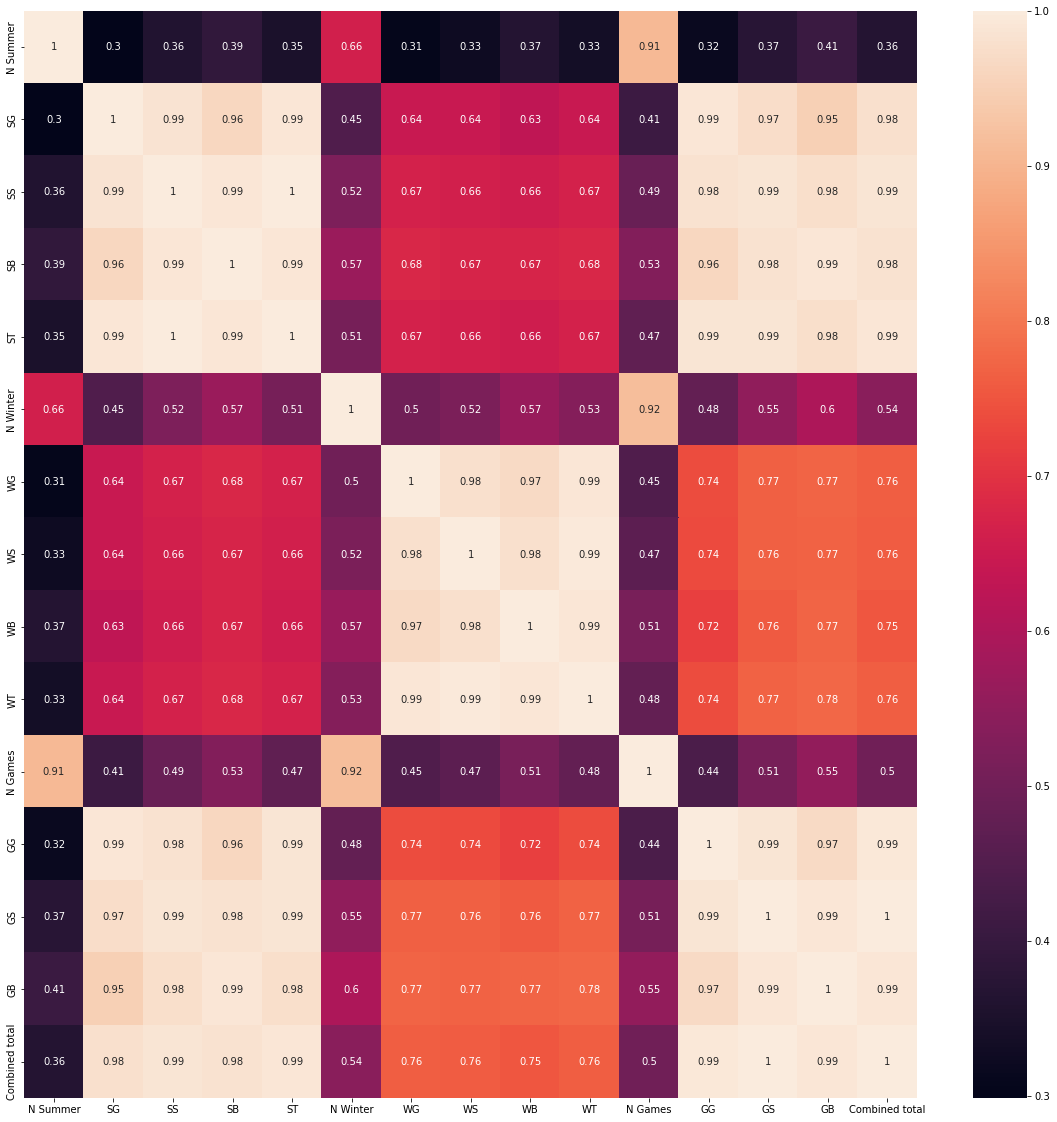

In [ ]:
corrMatrix=olympics_df.corr()
sb.heatmap(corrMatrix, annot=True)
plt.rcParams["figure.figsize"] = (20,20)
plt.show

Notar la muy alta y alta correlación de todos los pares del tipo $(f_{i},f_{j})$, con $f_{i} ∈ X, f_{j} ∈ X, X = \{SG,SS,SB,WG,WS,SB,GG,SG,SB,ST,WT,CT\}$, donde $CT$ se refirere a la columna "Combined total". Es decir, existe una alta correlación entre todos los pares relacionados a la cantidad de medallas ganadas por un país. También es de notar la muy alta correlación entre los pares formados por "N Games" y cualquiera de las categorías "N Winter" y "N Summer", y se destaca la alta correlación entre "N Winter" y "N Summer", además de la baja correlación entre "N Games" y cualquier categoría relacionada a la cantidad de medallas ganadas por un país.

Dado lo último visto se puede concluir que las variables que mejor describen el módelo y están relacionadas a nuestro objetivo son: "ST", "WT" y "N Games", debido a la baja correlación entre ellas dando a la posibilidad un módelo más simple y generalizado. A pesar de que "Combined total" podría aportar al objetivo de analizar por medallería los países, esta categoría no aporta mucho al modelo, pues es una combinación líneal de "ST" y "WT", por esto se decidió usar una variable menos correlacionada y que podría llegar a nutrir más el modelo: "N Games".

A continuación pasaremos a analizar las gráficas de pares de las tres variables escogidas, además de una gráfica 3D:

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

fig = px.scatter_3d(olympics_df, x="ST", y="WT", z="N Games",)
                    #color="Combined t",size='sepal-width')
fig.show()

<function matplotlib.pyplot.show>

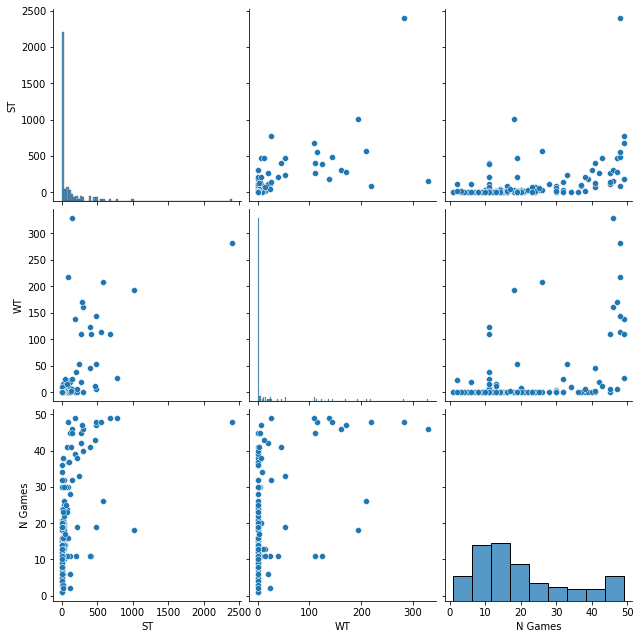

In [ ]:
sb.pairplot(olympics_df[['ST', 'WT', 'N Games']].dropna(),
            height=3,
            vars=['ST', 'WT', 'N Games'],
            kind="scatter")
plt.show

Teniendo en cuenta lo visto en la gráfica en 3D y lo mostrado en el pairplot, es notorio que los datos se pueden dividir en subgrupos, además de que hay ciertos outliers producidos por valores muy grandes en la cantidad total de medallas ganadas por algunos países en invierno y, especialmente, en verano.

A continuación mostraremos los países que contengan un total de medallas mayor a 500 para reconocer los outliers:

In [ ]:
olympics_df[
            olympics_df["Combined total"]>500]

Paises  N Summer   SG   SS   SB    ST  \
14              East Germany (GDR) [GDR]         5  153  129  127   409   
31                    Russia (RUS) [RUS]         5  132  121  142   395   
36         Great Britain (GBR) [GBR] [Z]        27  236  272  272   780   
77                      Sweden (SWE) [Z]        26  143  164  176   483   
88                     China (CHN) [CHN]         9  201  146  126   473   
112                  Italy (ITA) [M] [S]        26  198  166  185   549   
131  United States (USA) [P] [Q] [R] [Z]        26  976  757  666  2399   
136              Germany (GER) [GER] [Z]        15  174  182  217   573   
139             France (FRA) [O] [P] [Z]        27  202  223  246   671   
144             Soviet Union (URS) [URS]         9  395  319  296  1010   

     N Winter  WG   WS  WB   WT  N Games    GG   GS   GB  Combined total  
14          6  39   36  35  110       11   192  165  162             519  
31          6  49   40  35  124       11   181  161  177             519  
36         22  10    4  12   26       49   246  276  284             806  
77         22  50   40  54  144       48   193  204  230             627  
88         10  12   22  19   53       19   213  168  145             526  
112        22  37   34  43  114       48   235  200  228             663  
131        22  96  102  84  282       48  1072  859  750            2681  
136        11  78   78  53  209       26   252  260  270             782  
139        22  31   31  47  109       49   233  254  293             780  
144         9  78   57  59  194       18   473  376  355            1204

Así reconocemos que **Estados Unidos** y la **Unión Soviética** son nuestros outliers. Se procederá a hacer un análisis con Z-score para confirmar que dichos valores son atípicos. Notar que por facilidad haremos el análisis sobre la suma de "WT" y "ST" ("Combined total"), y no sobre cada una.

In [ ]:
from scipy import stats
import numpy as np
z = np.abs(stats.zscore(olympics_df["Combined total"]))
print(z)

[4.03468250e-01 3.34736712e-01 3.86285366e-01 3.31300135e-01
 2.76314905e-01 6.03448780e-01 4.10341404e-01 6.96236356e-01
 1.52598137e-01 3.89721943e-01 2.96934366e-01 2.11019944e-01
 8.78374931e-01 3.23179457e-02 1.36980543e+00 3.72539058e-01
 3.82848789e-01 4.10341404e-01 3.72539058e-01 5.86265895e-01
 3.79412212e-01 3.24426982e-01 4.10341404e-01 4.10341404e-01
 4.03468250e-01 4.00031673e-01 4.03468250e-01 3.79412212e-01
 4.10341404e-01 3.79412212e-01 4.03468250e-01 1.36980543e+00
 1.22546920e+00 4.06904827e-01 3.24426982e-01 3.41609866e-01
 2.35610300e+00 5.01598997e-02 4.06904827e-01 3.62229327e-01
 4.06904827e-01 1.73217598e-01 4.10341404e-01 3.82848789e-01
 4.10341404e-01 4.10341404e-01 4.00031673e-01 4.10341404e-01
 3.14117251e-01 4.03468250e-01 4.06904827e-01 3.89721943e-01
 1.11359214e-01 1.14795791e-01 4.03468250e-01 5.70330535e-02
 4.10341404e-01 4.06904827e-01 4.10341404e-01 2.07583367e-01
 2.59132021e-01 5.48440011e-03 4.10341404e-01 1.17735712e+00
 4.10341404e-01 1.835273

Ahora con el Z-Score calculado, usaremos un límite de $|Z|\le3$, es decir que consideraremos como outliers todo aquel sample cuyo valor absoluto de Z-Score sea mayor que 3. A contnuación confirmamos las sospechas de que los samples de la URS y de USA son outliers:

In [ ]:
data=olympics_df.copy() #Trabajaremos sobre una copia de nuestro dataset preparado por buenas prácticas
data["Z_CT"]=z
data[data["Z_CT"]>3]

Paises  N Summer   SG   SS   SB    ST  \
131  United States (USA) [P] [Q] [R] [Z]        26  976  757  666  2399   
144             Soviet Union (URS) [URS]         9  395  319  296  1010   

     N Winter  WG   WS  WB   WT  N Games    GG   GS   GB  Combined total  \
131        22  96  102  84  282       48  1072  859  750            2681   
144         9  78   57  59  194       18   473  376  355            1204   

         Z_CT  
131  8.799685  
144  3.723861

Por lo que en un nuevo dataframe, copiado en la última celda de olympics_df, procederemos a eliminar estos outliers:

In [ ]:
data=data[data["Z_CT"]<=3]
data[data["Combined total"]>1200] #Confirmamos que outliers ya no están más

Empty DataFrame
Columns: [Paises, N Summer, SG, SS, SB, ST, N Winter, WG, WS, WB, WT, N Games, GG, GS, GB, Combined total, Z_CT]
Index: []

Ahora analicemos de nuevo el pair plot y el gráfico 3d de nuevo:

<function matplotlib.pyplot.show>

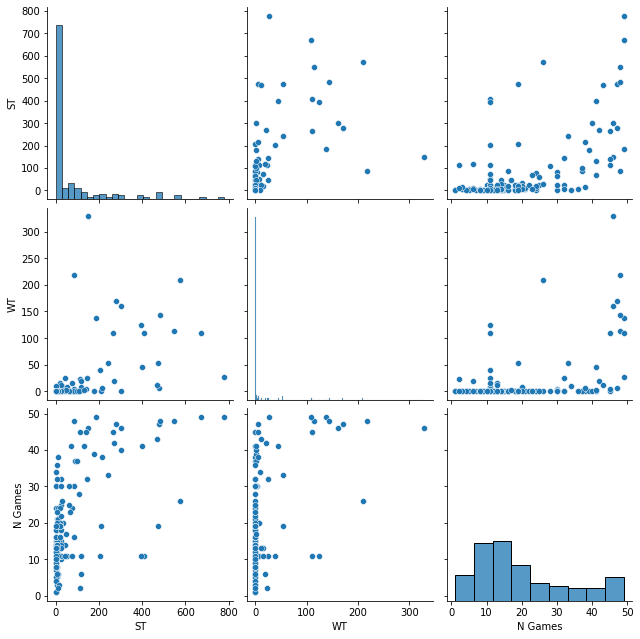

In [ ]:
data_copy=data.copy() #Guardando 
data=data[['ST', 'WT', 'N Games']]
sb.pairplot(data,
            height=3,
            vars=['ST', 'WT', 'N Games'],
            kind="scatter")
plt.show

In [ ]:
fig = px.scatter_3d(data, x="ST", y="WT", z="N Games",)
fig.show()

Ya sin outliers las tendencias de los samples a reunirse por grupos para estas tres variables es más clara.

##Establecimiento de clústeres##

Para establecer los clústeres usaremos tres técnicas: Elbow curve, estadístico de GAP y Silhouette score.

###Elbow curve###

A continuación se encuentra el método de elbow_curve usando KMeans de la librería sklearn:

In [ ]:
def elbow_curve(data, maxClusters = 15):

  # rango de valores del parámetro a optimizar (cantidad de clusters)
  maxClusters = range(1, maxClusters + 1)
  inertias = []

  # se ejecuta el modelo para el rango de clusters y se guarda la inercia
  # respectiva obtenida para cada valor
  for k in maxClusters:
    kmeanModel = KMeans(n_clusters = k)
    kmeanModel.fit(data)
    inertias.append(kmeanModel.inertia_)
  
# Grafico de los resultados obtenidos para cada valor del rango
  print("Valores: ",inertias)
  plt.figure(figsize=(10, 8))
  plt.plot(maxClusters, inertias, 'bx-')
  plt.xlabel('k')
  plt.ylabel('Inertia')
  plt.title('The Elbow Method showing the optimal k')
  plt.show()

Valores:  [3435777.9791666674, 932762.0528022232, 511816.90510878, 380348.049498362, 273167.9033944659, 189607.74028207778, 147836.0326797386, 109195.977124183, 94363.56045751635, 82751.92216117217, 71935.08882783884, 64327.17216117217, 55976.438827838836, 48000.27216117217, 40413.3629217274]


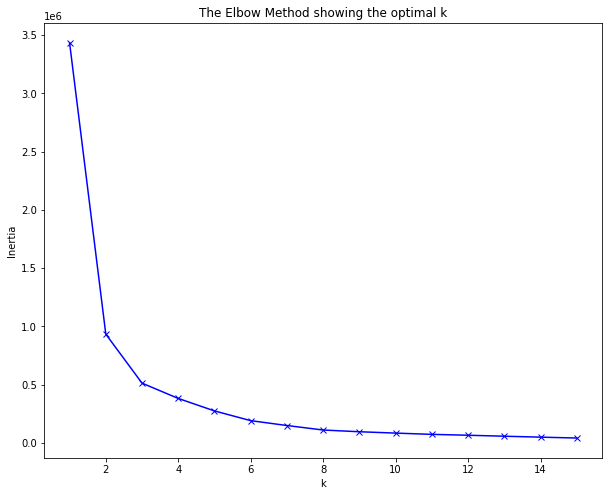

In [ ]:
elbow_curve(np.array(data))

Se puede apreciar en el gráfico que a partir de k=6 ya no hay una mejora significativa en la inercia (reducción en la variación intra-cluster). Entonces la cantidad óptima de clusters será 6, de acuerdo a esta prueba.

###Silhouette score###

Para confirmar lo anterior procederemos a hacer un análisis de coeficiente de silueta:

For n_clusters = 2 The average silhouette_score is : 0.8068473851563832
For n_clusters = 3 The average silhouette_score is : 0.7535083260188549
For n_clusters = 4 The average silhouette_score is : 0.6979016868106737
For n_clusters = 5 The average silhouette_score is : 0.7241105926947449
For n_clusters = 6 The average silhouette_score is : 0.7005909814622959
For n_clusters = 7 The average silhouette_score is : 0.702190755250307
For n_clusters = 8 The average silhouette_score is : 0.7016176912830547
For n_clusters = 9 The average silhouette_score is : 0.6354308799040684
For n_clusters = 10 The average silhouette_score is : 0.6369699697423112
For n_clusters = 11 The average silhouette_score is : 0.5055769411506239
For n_clusters = 12 The average silhouette_score is : 0.624790021547109
For n_clusters = 13 The average silhouette_score is : 0.6278345474454221
For n_clusters = 14 The average silhouette_score is : 0.6251538239847623


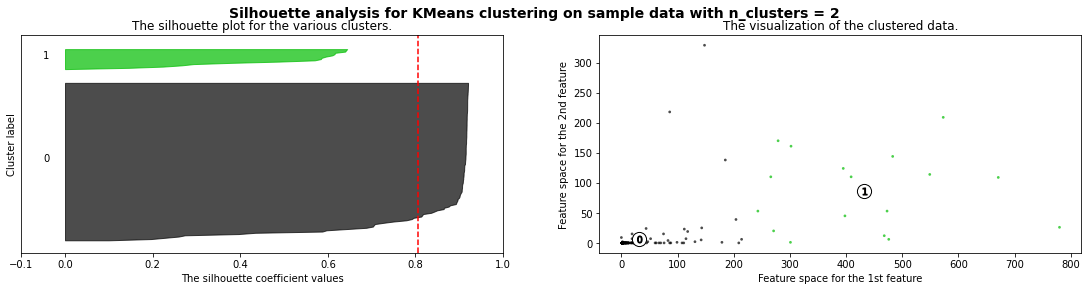

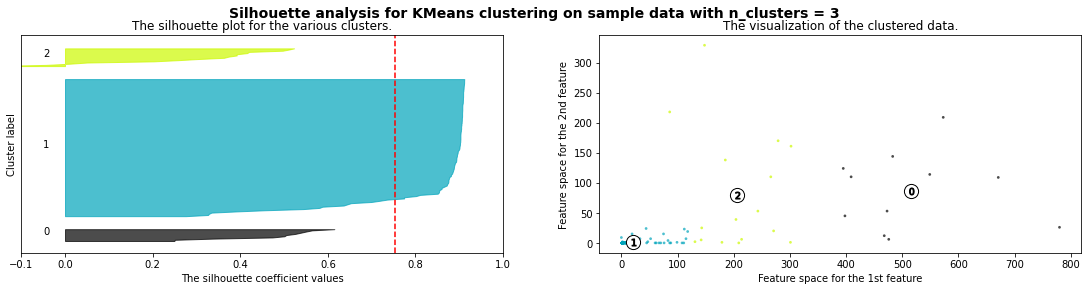

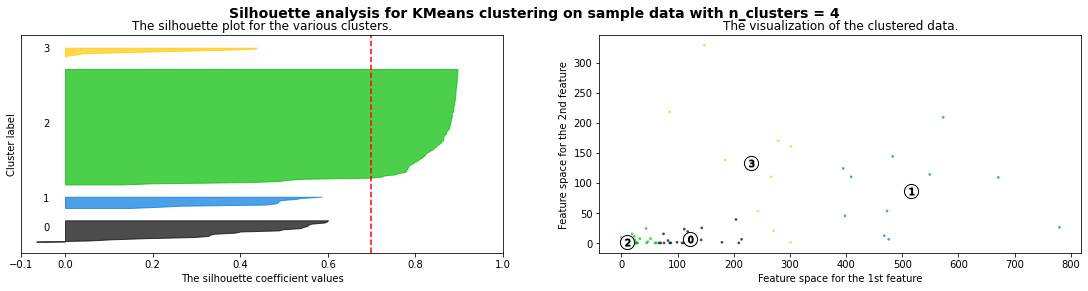

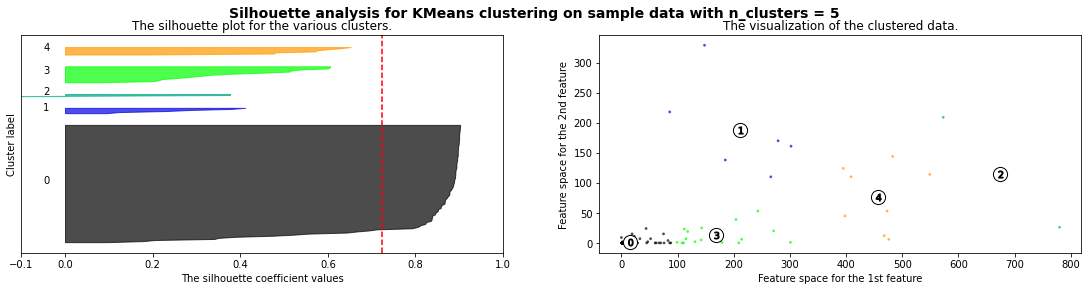

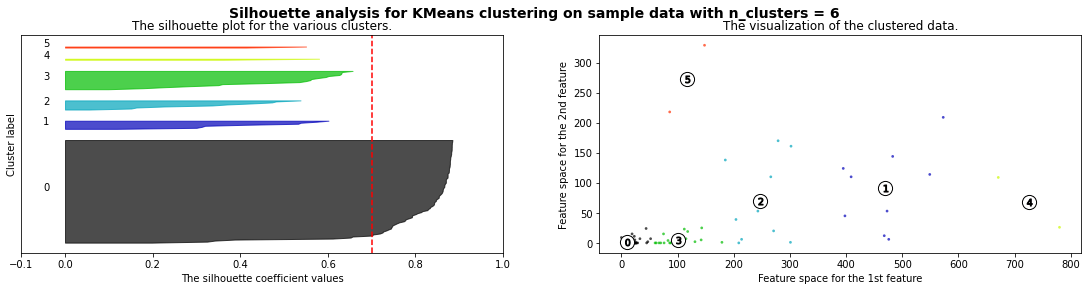

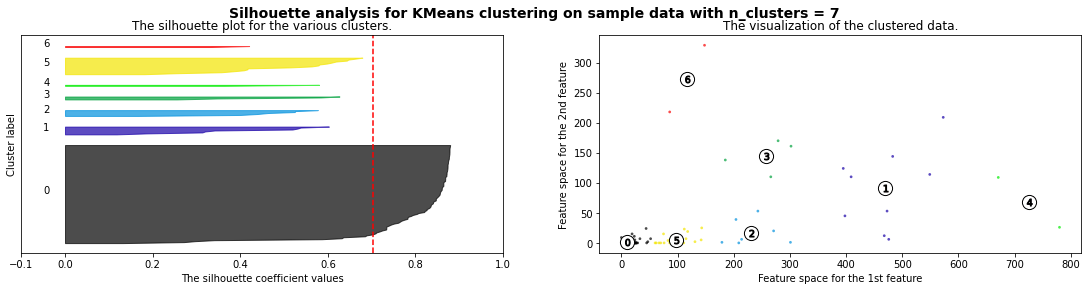

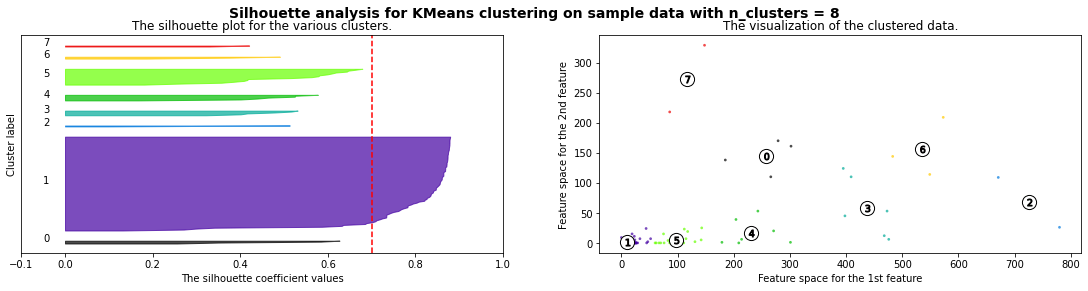

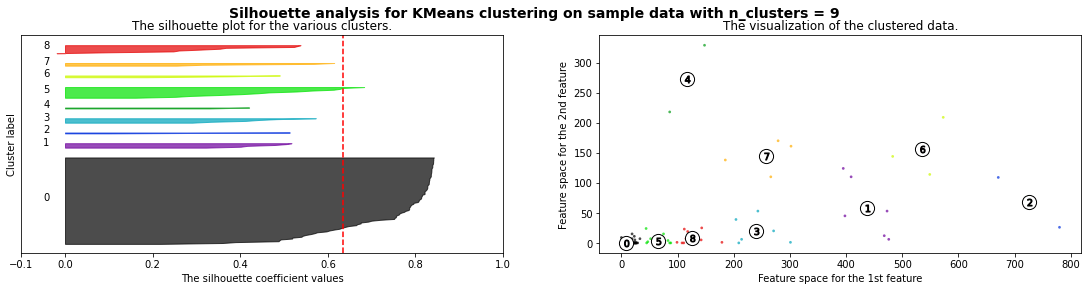

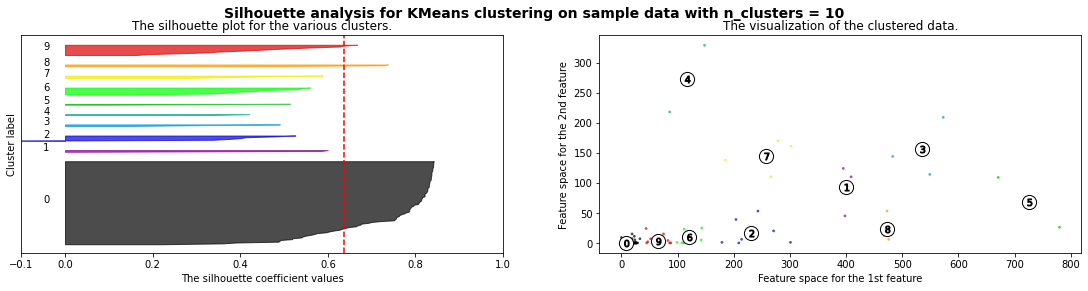

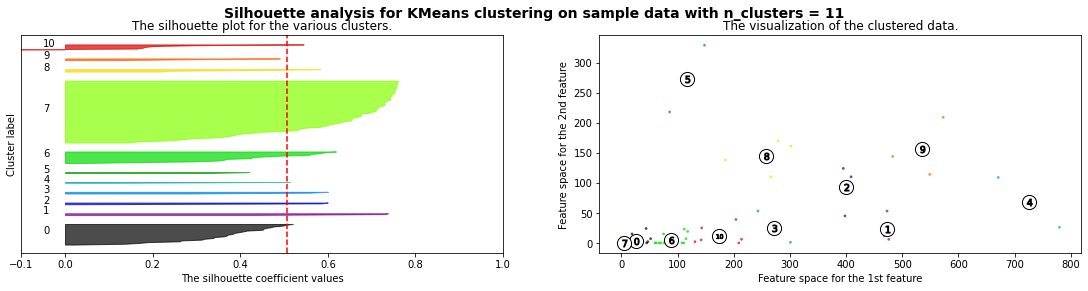

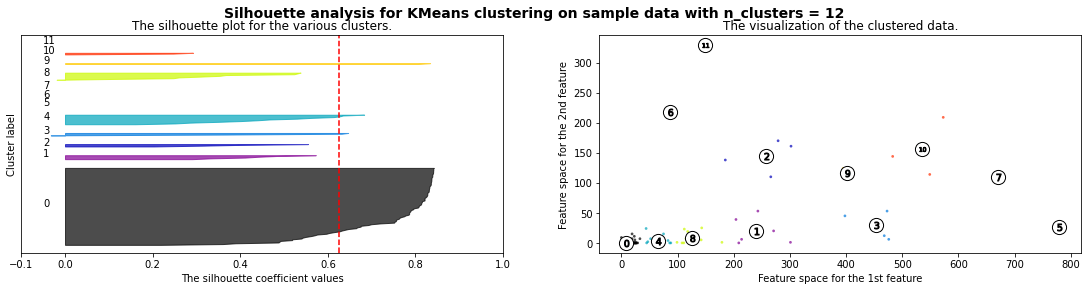

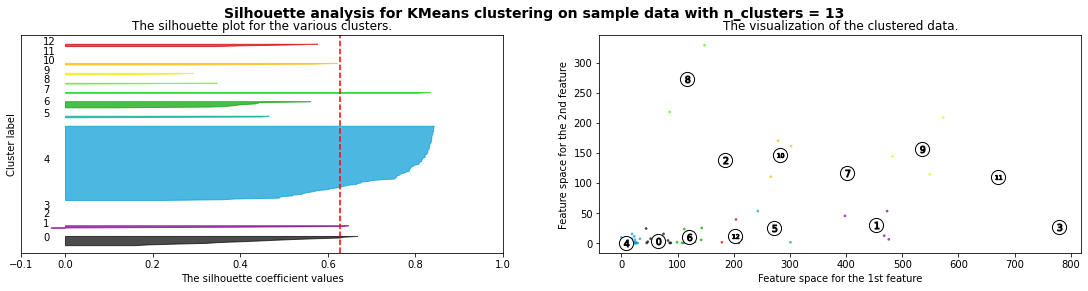

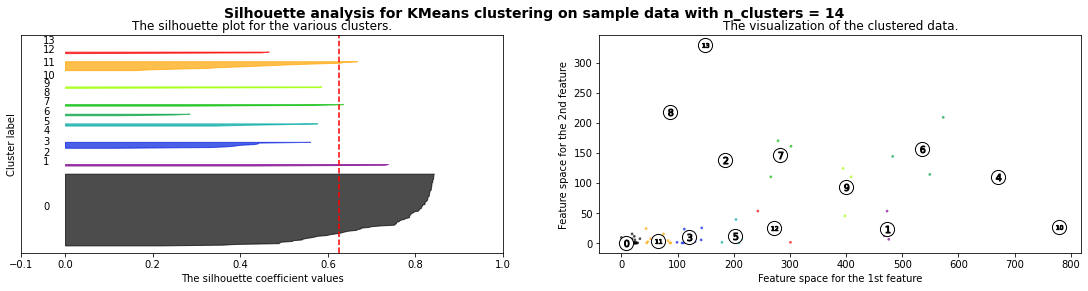

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

colors_k_means = ['cyan','purple','orange']
range_n_clusters = list(range(2,15))
X = np.array(data)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(19, 4)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = plt.cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

Se puede notar que el mejor score fue para 2 y 3 clústeres, y para 8, 7, 6, 5 y 4 se tiene un score muy similar, este, no distando mucho del score para 3. Así, concluiremos de este método, que lo más conveniente es usar 6 clústeres, pues es la cantidaed que mejor reparte los samples y es de las que más  silhouette score tiene.

###Estadistico de GAP###

A continuación se hace el análisis por estadístico de gap:

In [ ]:
# nrefs es la cantidad de datos ("datasets") de referencia contra los que se va a comparar
def optimalK(data, nrefs=3, maxClusters=15):

    gaps = np.zeros((len(range(1, maxClusters+1)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in enumerate(range(1, maxClusters+1)):

        # guardara los resultados de dispersión de cada distribución simulada
        refDisps = np.zeros(nrefs)

        # Genera las muestras aleatorias indicadas con nrefs y ejecuta k-means
        # en cada bucle obteniendo los resultados de dispersión (inercia)
        # para cada conjunto generado.
        for i in range(nrefs):
            
            # Crea nuevo conjunto aleatorio de referencia
            # Se puede usar una semilla para tener reproducibilidad
            np.random.seed(0)
            randomReference = np.random.random_sample(size=data.shape)
            
            # se ajusta el modelo al conjunto de referencia
            km = KMeans(k)
            km.fit(randomReference)
            # se guarda la dispersión obtenida
            refDisp = km.inertia_
            refDisps[i] = refDisp

        # Se ajusta el modelo a los datos originales y se guarda su inercia
        km = KMeans(k)
        km.fit(data)
        
        origDisp = km.inertia_

        # Calcula el estadístico de gap para k clusters usando el promedio de
        # las dispersiones de los datos simulados y la dispersión de los datos originales.
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)

        # Guarda el estadístico de gap obtenido en este bucle.
        gaps[gap_index] = gap
        
        resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap}, ignore_index=True)

    # Selecciona el "primer máximo" de los estadísticos obtenidos y devuelve 
    # su respectivo número de clusters    
    for i in range(0, len(gaps)-1):
      if gaps[i+1] <= gaps[i]:
        return (i+1, resultsdf)
    return (len(gaps), resultsdf)
    #return (gaps.argmax() + 1, resultsdf)  # Plus 1 because index of 0 means 1 cluster is optimal, index 2 = 3 clusters are optimal

La cantidad óptima de clusters es:  20


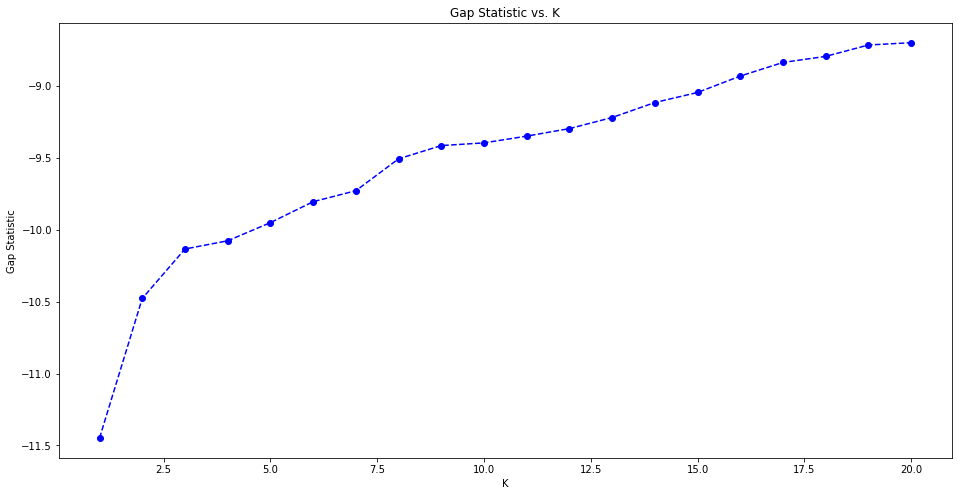

In [ ]:
k, gapdf = optimalK(np.array(data), nrefs=5, maxClusters=20)
print('La cantidad óptima de clusters es: ', k)

plt.figure(figsize=(16,8))
plt.plot(gapdf['clusterCount'], gapdf['gap'], linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Gap Statistic');
plt.title('Gap Statistic vs. K');

Se puede ver que el resultado dado de este método es que los samples se deben dividir en 20 clústeres, siendo este número muy grande para 146 datos pues se puede generar overfitting (un módelo demasiado complejo que sólo funciona para los datos usados para entrenarlo), viendo la tendencia en la gráfica a no decaer y dado un resultado que dista mucho de lo concluido anteriormente: descartaremos este método y no lo tendremos en cuenta.

##Dendrograma y módelo##

###Dendrograma###

A continuación se presenta el dendrograma agrupando hasta la última cantidad p=30 de hojas y usando el método de linkage "ward" que busca pares de clústeres que luego de ser unidos den la menor varianza posible:

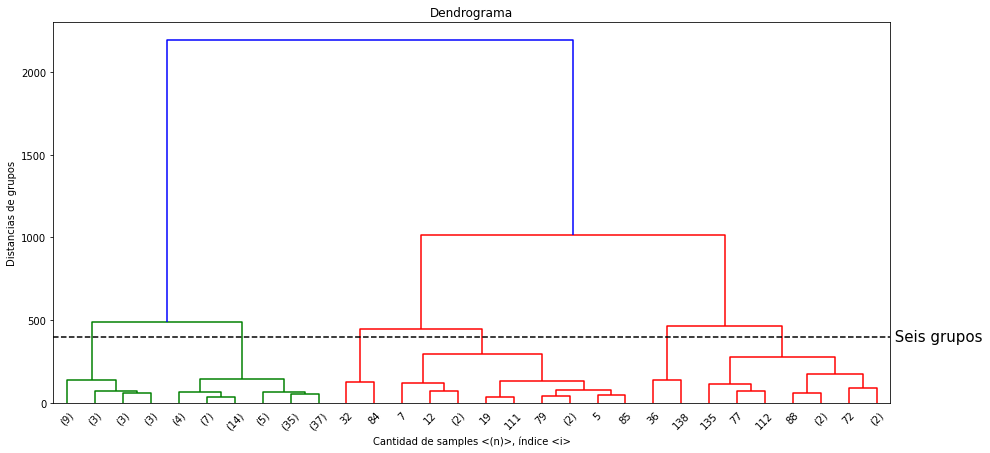

In [ ]:
import scipy.cluster.hierarchy as shc
from matplotlib import pyplot
pyplot.figure(figsize=(15, 7))  
pyplot.title("Dendrograma") 
dend = shc.dendrogram(shc.linkage(data, method='ward'),truncate_mode='lastp')# Dendrograma usando ward como método de linkage.
ax = plt.gca()
bounds = ax.get_xbound()
ax.plot(bounds, [400, 400], '--', c='k')
ax.text(bounds[1], 400, ' Seis grupos', va='center', fontdict={'size': 15})
plt.xlabel("Cantidad de samples <(n)>, índice <i>")
plt.ylabel("Distancias de grupos")
plt.show()

Se puede notar una división marcada para una distancia de 400, donde resultan 6 clusteres, como se había concluido con las anteriores técnicas. Es notable, además, el hecho de que el lado izquierdo es el que más samples tiene, esto debido a que la cantidad de paises con pocas medallas es mayor que la cantidad de países con muchas medallas, estos representando los grupos más dispersos.  

###Modelo de clustering aglomerativo###

Para el modelo usaremos un módelo de clustering aglomerativo:

Para comenzar haremos una normalización de los datos:

In [ ]:
data_normalized=(data - data.min())/(data.max()-data.min())
data_normalized

ST        WT   N Games
0    0.003846  0.000000  0.229167
1    0.029487  0.000000  0.291667
2    0.010256  0.000000  0.041667
3    0.030769  0.000000  0.500000
4    0.042308  0.021277  0.395833
..        ...       ...       ...
140  0.001282  0.000000  0.145833
141  0.015385  0.000000  0.020833
142  0.001282  0.000000  0.145833
143  0.001282  0.000000  0.208333
145  0.001282  0.000000  0.187500

[144 rows x 3 columns]

Ya con los datos normalizados usaremos la clase AgglomerativeClustering de la librería sklearn con el método de linkage "ward" explicado anteriormente y pasando 6 clústeres como argumento:

In [ ]:
clustering= AgglomerativeClustering(n_clusters=6,linkage="ward")
clustering.fit(data_normalized)
clustering.labels_

array([0, 0, 0, 5, 5, 2, 5, 1, 5, 5, 0, 0, 1, 2, 3, 5, 5, 0, 0, 2, 5, 0,
       0, 0, 5, 0, 0, 5, 0, 0, 0, 3, 1, 0, 5, 5, 4, 0, 0, 0, 0, 2, 0, 0,
       5, 0, 0, 0, 5, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 5, 0, 0, 0, 1, 0, 5,
       0, 0, 0, 4, 0, 0, 4, 0, 0, 0, 2, 4, 5, 2, 0, 5, 5, 0, 1, 0, 5, 0,
       3, 2, 0, 0, 2, 1, 5, 0, 0, 0, 0, 0, 5, 5, 0, 0, 5, 0, 0, 2, 0, 2,
       0, 2, 4, 0, 2, 5, 0, 2, 2, 0, 2, 0, 2, 0, 2, 0, 4, 5, 0, 2, 0, 0,
       0, 2, 0, 3, 2, 0, 4, 0, 0, 0, 0, 0])

Asignando cada clase a cada sample obtenemos:

In [ ]:
final=data_copy
final["cluster"]=clustering.labels_
final

Paises  N Summer  SG  SS  SB  ST  N Winter  WG  WS  \
0                   Syria (SYR)        12   1   1   1   3         0   0   0   
1                 Nigeria (NGR)        15   3   8  12  23         0   0   0   
2    Russian Empire (RU1) [RU1]         3   1   4   3   8         0   0   0   
3                Mongolia (MGL)        12   2   9  13  24        13   0   0   
4                 Estonia (EST)        11   9   9  15  33         9   4   2   
..                          ...       ...  ..  ..  ..  ..       ...  ..  ..   
140  United Arab Emirates (UAE)         8   1   0   0   1         0   0   0   
141     Australasia (ANZ) [ANZ]         2   3   4   5  12         0   0   0   
142               Grenada (GRN)         8   1   0   0   1         0   0   0   
143                 Niger (NIG)        11   0   0   1   1         0   0   0   
145             Macedonia (MKD)         5   0   0   1   1         5   0   0   

     WB  WT  N Games  GG  GS  GB  Combined total      Z_CT  cluster  
0     0   0       12   1   1   1               3  0.403468        0  
1     0   0       15   3   8  12              23  0.334737        0  
2     0   0        3   1   4   3               8  0.386285        0  
3     0   0       25   2   9  13              24  0.331300        5  
4     1   7       20  13  11  16              40  0.276315        5  
..   ..  ..      ...  ..  ..  ..             ...       ...      ...  
140   0   0        8   1   0   0               1  0.410341        0  
141   0   0        2   3   4   5              12  0.372539        0  
142   0   0        8   1   0   0               1  0.410341        0  
143   0   0       11   0   0   1               1  0.410341        0  
145   0   0       10   0   0   1               1  0.410341        0  

[144 rows x 18 columns]

##Carácterísticas diferentes clusteres##

A continuación se presentan los datos en una gráfica 3D organizados por las categorías escogidas al principio y con colores dados por el clúster:

In [ ]:
fig = px.scatter_3d(final, x="ST", y="WT", z="N Games",color="cluster")
fig.show()

A continuación se hace un resumen de estadísticas descriptivas para cada uno de los clústeres:

In [ ]:
final_copy=final.copy().drop(["Paises","N Summer","SG","SS","SB","N Winter","WG","WS","WB","GG","GS","GB","Combined total","Z_CT"],axis=1)

#resumen = final.groupby(['cluster']).agg(['mean', 'min', 'max'])
resumen = final_copy.groupby(['cluster']).agg(['mean', 'min', 'max',"count"])

###Grupo 0###

A continuación se presentan gráficas y tablas con relación al grupo 0

GRUPO 0:
                        Paises  N Summer  SG  SS  SB  ST  N Winter  WG  WS  \
0                  Syria (SYR)        12   1   1   1   3         0   0   0   
1                Nigeria (NGR)        15   3   8  12  23         0   0   0   
2   Russian Empire (RU1) [RU1]         3   1   4   3   8         0   0   0   
10              Slovenia (SLO)         6   4   6   9  19         7   2   4   
11            Kazakhstan (KAZ)         5  16  17  19  52         6   1   3   

    WB  WT  N Games  GG  GS  GB  Combined total      Z_CT  cluster  
0    0   0       12   1   1   1               3  0.403468        0  
1    0   0       15   3   8  12              23  0.334737        0  
2    0   0        3   1   4   3               8  0.386285        0  
10   9  15       13   6  10  18              34  0.296934        0  
11   3   7       11  17  20  22              59  0.211020        0  
(79, 18)


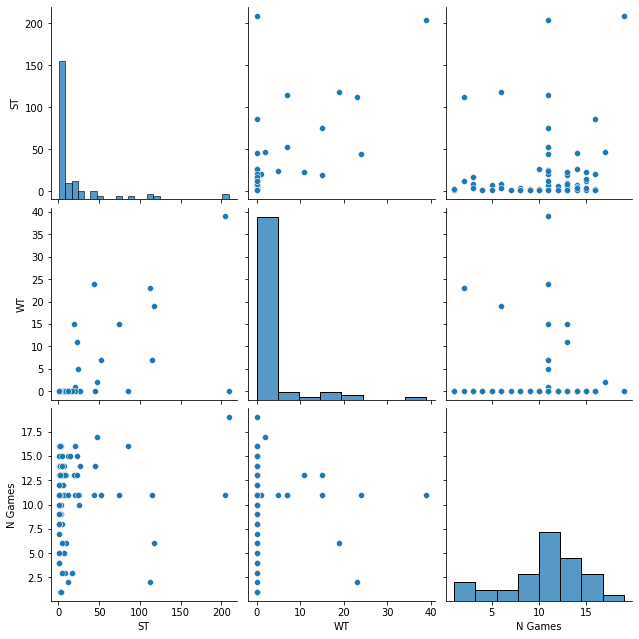

In [ ]:
#Se separan por labels por medio de una máscara.
#Grupo 0
print("GRUPO 0:")
is_G=final.loc[:, 'cluster']==0
C3_G=final[is_G]
print(C3_G.head())
print(C3_G.shape)
sb.pairplot(C3_G,
            height=3, 
            vars=['ST', 'WT', "N Games"],
            kind='scatter')
plt.show()

Con base en el pairplot para este grupo 0 y en la gráfica 3D se puede ver que este grupo se consituye por los países que menos participaciones tienen en juegos olímpicos (ya sea de verano o invierno) además tienen la menor cantidad de medallas ganadas tanto en invierno como en verano, en promedio.

In [ ]:
resumen.iloc[0].unstack()

mean  min    max  count
ST       19.468354  1.0  209.0   79.0
WT        2.126582  0.0   39.0   79.0
N Games  10.620253  1.0   19.0   79.0

En promedio los países pertenecientes a este grupo han ganado 19.5 medallas en verano, 2 en invierno y tienen 11 participaciones en los juegos olímpicos. El que más medallas en verano ha ganado en verano ganó 15, el que menos 1; para invierno son 39 y 0 en ese mismo orden y 19 es el número máximo de participaciones para un país dentro del grupo, mientras que 1 es el mínimo.

###Grupo 1###

A continuación se presentan gráficas y tablas con relación al grupo 1

GRUPO 1:
                   Paises  N Summer   SG  SS   SB   ST  N Winter   WG   WS  \
7       Switzerland (SUI)        27   47  73   65  185        22   50   40   
12  Netherlands (NED) [Z]        25   77  85  104  266        20   37   38   
32       Norway (NOR) [Q]        24   56  49   43  148        22  118  111   
63          Finland (FIN)        24  101  84  117  302        22   42   62   
84          Austria (AUT)        26   18  33   35   86        22   59   78   

     WB   WT  N Games   GG   GS   GB  Combined total      Z_CT  cluster  
7    48  138       49   97  113  113             323  0.696236        1  
12   35  110       45  114  123  139             376  0.878375        1  
32  100  329       46  174  160  143             477  1.225469        1  
63   57  161       46  143  146  174             463  1.177357        1  
84   81  218       48   77  111  116             304  0.630941        1  
(6, 18)


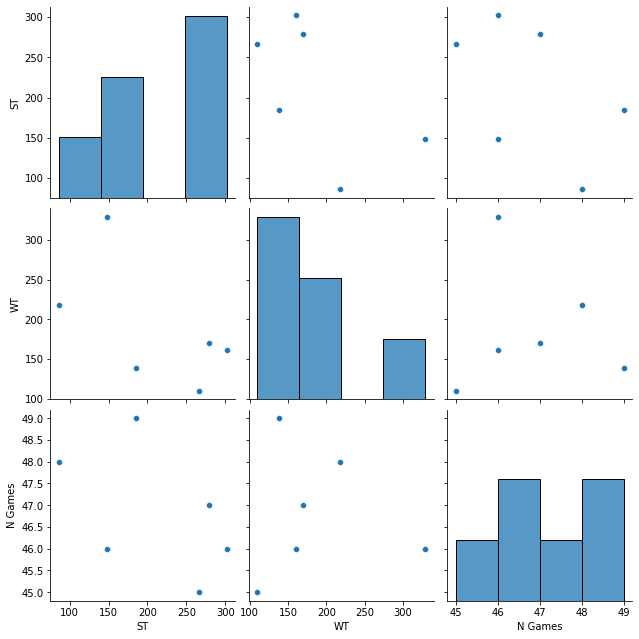

In [ ]:
#Grupo 1
print("GRUPO 1:")
is_G=final.loc[:, 'cluster']==1
C3_G=final[is_G]
print(C3_G.head())
print(C3_G.shape)

sb.pairplot(C3_G,
            height=3, 
            vars=['ST', 'WT', "N Games"],
            kind='scatter')
plt.show()

Con base en el pairplot para este grupo 1 y en la gráfica 3D se puede ver que este grupo se consituye por los países que tienen entre 45 y 48 participaciones en juegos olímpicos (ya sea de verano o invierno) y que además han ganado una cantidad considerable de medallas tanto en juegos olímpicos de verano (211 en promedio) como de invierno (188 en promedio).

In [ ]:
resumen.iloc[1].unstack()

mean    min    max  count
ST       211.000000   86.0  302.0    6.0
WT       187.666667  110.0  329.0    6.0
N Games   46.833333   45.0   49.0    6.0

En promedio los países de este grupo han ganado 211 medallas en verano (siendo 86 el mínimo y 302 el máximo), 188 en invierno (siendo 110 el mínimo y 329 el máximo) y tienen 47 participaciones (siendo 45 el mínimo y 49 el máximo).

### Grupo 2###

A continuación se presentan gráficas y tablas con relación al cluster 2.

GRUPO 2:
               Paises  N Summer  SG  SS   SB   ST  N Winter  WG  WS  WB  WT  \
5   South Korea (KOR)        16  81  82   80  243        17  26  17  10  53   
13   Greece (GRE) [Z]        27  30  42   39  111        18   0   0   0   0   
19       Poland (POL)        20  64  82  125  271        22   6   7   7  20   
41    Argentina (ARG)        23  18  24   28   70        18   0   0   0   0   
52       Turkey (TUR)        21  39  25   24   88        16   0   0   0   0   

    N Games   GG  GS   GB  Combined total      Z_CT  cluster  
5        33  107  99   90             296  0.603449        2  
13       45   30  42   39             111  0.032318        2  
19       42   70  89  132             291  0.586266        2  
41       41   18  24   28              70  0.173218        2  
52       37   39  25   24              88  0.111359        2  
(22, 18)


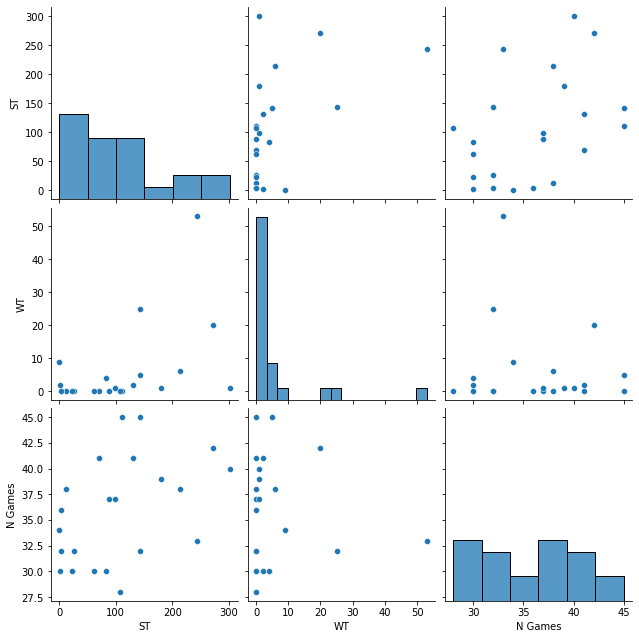

In [ ]:
#Grupo 2
print("GRUPO 2:")
is_G=final.loc[:, 'cluster']==2
C3_G=final[is_G]
print(C3_G.head())
print(C3_G.shape)

sb.pairplot(C3_G,
            height=3, 
            vars=['ST', 'WT', "N Games"],
            kind='scatter')
plt.show()

Se puede notar del anterior conjunto de gráficas que la mayoría de países en este cluster
suelen tener más medallas de verano ("ST") ganadas por número de juegos que medallas de invierno ("WT")
Además, comparando con la gráfica 3D del principio, se puede ver que este cluster es de los clústeres que más
cantidad de juegos ha jugado "N Games", pero los países de este no son necesariamente de los que más medallas
han ganado.

In [ ]:
resumen.iloc[2].unstack()

mean   min    max  count
ST       105.318182   0.0  301.0   22.0
WT         5.863636   0.0   53.0   22.0
N Games   35.909091  28.0   45.0   22.0

De la anterior tabla podemos confirmar que la tendencia en este cluster es a la de ganar más medallas de
verano que de invierno  con un promedio de la primera mucho más grande que la segunda
además de que el número de juegos jugados en comparación con los otros países es bastante alto.
Para este cluster la cantidad de países es de 22.

###Grupo 3###


A continuación se presentan gráficas y tablas con relación al cluster 3.

GRUPO 3:
                       Paises  N Summer   SG   SS   SB   ST  N Winter  WG  WS  \
14   East Germany (GDR) [GDR]         5  153  129  127  409         6  39  36   
31         Russia (RUS) [RUS]         5  132  121  142  395         6  49  40   
88          China (CHN) [CHN]         9  201  146  126  473        10  12  22   
136   Germany (GER) [GER] [Z]        15  174  182  217  573        11  78  78   

     WB   WT  N Games   GG   GS   GB  Combined total      Z_CT  cluster  
14   35  110       11  192  165  162             519  1.369805        3  
31   35  124       11  181  161  177             519  1.369805        3  
88   19   53       19  213  168  145             526  1.393861        3  
136  53  209       26  252  260  270             782  2.273625        3  
(4, 18)


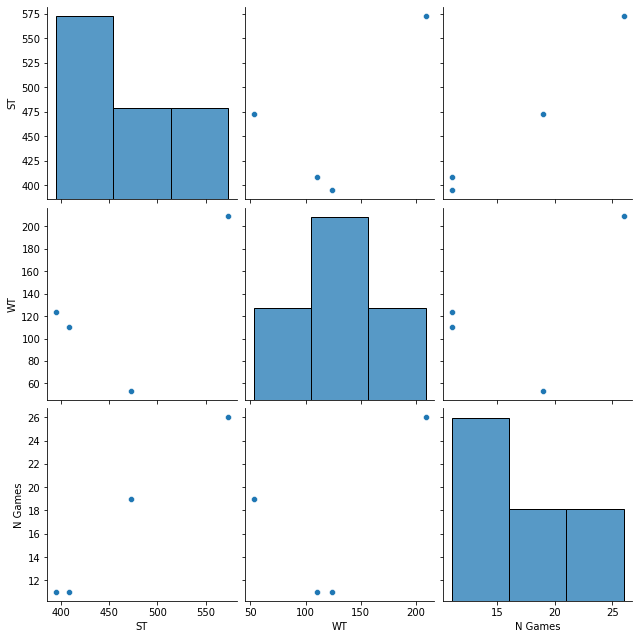

In [ ]:
#Grupo 3
print("GRUPO 3:")
is_G=final.loc[:, 'cluster']==3
C3_G=final[is_G]
print(C3_G.head())
print(C3_G.shape)

sb.pairplot(C3_G,
            height=3, 
            vars=['ST', 'WT', "N Games"],
            kind='scatter')
plt.show()

Del anterior conjunto de gráficas se puede concluir que, al igual que con el anterior cluster=2, 
se nota una tendencia de los países pertenecientes a l cluster=3 a ganar más medallas en verano
por cantidad de juegos jugados que en invierno, además se puede notar que a este grupo pertenecen pocos
samples.


In [ ]:
resumen.iloc[3].unstack()

mean    min    max  count
ST       462.50  395.0  573.0    4.0
WT       124.00   53.0  209.0    4.0
N Games   16.75   11.0   26.0    4.0

De la anterior tabla y de la gráfica 3D, además, podemos agregar que el promedio de juegos 
jugados es bastante bajo si se pone en comparación con los clústeres 1, 2, 4, e incluso 5, esto no quitando
que los cuatro países pertenecientes a este clúster=3 son de los que más medallas, tanto en invierno como en verano, tienen.


###Grupo 4###

A continuación se presentan gráficas y tablas con relación al cluster 4.

GRUPO 4:
                            Paises  N Summer   SG   SS   SB   ST  N Winter  \
36   Great Britain (GBR) [GBR] [Z]        27  236  272  272  780        22   
69                   Hungary (HUN)        25  167  144  165  476        22   
72                     Japan (JPN)        21  130  126  142  398        20   
77                Sweden (SWE) [Z]        26  143  164  176  483        22   
112            Italy (ITA) [M] [S]        26  198  166  185  549        22   

     WG  WS  WB   WT  N Games   GG   GS   GB  Combined total      Z_CT  \
36   10   4  12   26       49  246  276  284             806  2.356103   
69    0   2   4    6       47  167  146  169             482  1.242652   
72   10  17  18   45       41  140  143  160             443  1.108626   
77   50  40  54  144       48  193  204  230             627  1.740956   
112  37  34  43  114       48  235  200  228             663  1.864672   

     cluster  
36         4  
69         4  
72         4  
77         4  
11

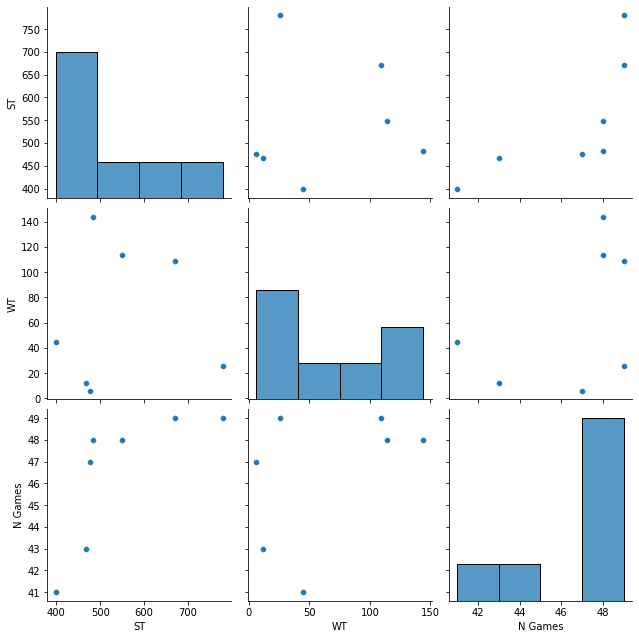

In [ ]:
#Grupo 4
print("GRUPO 4:")
is_G=final.loc[:, 'cluster']==4
C3_G=final[is_G]
print(C3_G.head())
print(C3_G.shape)

sb.pairplot(C3_G,
            height=3, 
            vars=['ST', 'WT', "N Games"],
            kind='scatter')
plt.show()

Apoyándonos con el pairplot y el gráfico 3D se evidencia que es uno de los grupos con mayor cantidad de 
participaciones en juegos olímpicos(verano e invierno incluidas) y que presentan una gran cantidad de medallas en los juegos 
de verano(todos sobrepasan de las 390 medallas) pero no tanta medallería para los juegos de invierno(ninguno supera las 150 medallas).

In [ ]:
resumen.iloc[4].unstack()

mean    min    max  count
ST       546.428571  398.0  780.0    7.0
WT        65.142857    6.0  144.0    7.0
N Games   46.428571   41.0   49.0    7.0

En el clúster 4 se pueden observar un total de 7 países los cuales poseen en promedio 46.42 participaciones
en juegos olímpicos(invierno y verano), teniendo como máximo un país con 49 participaciones y un país con el mínimo 41 participaciones.
Ahora bien, si nos vamos para los juegos de verano exclusivamente, se detalla un promedio de 546 medallas, siendo el máximo 780 medallas
y el mínimo 398. Por otro lado, si detallamos el medallerío de invierno vemos un promedio de 65 medallas, con un mínimo de 6 medallas y
un máximo de 144 medallas

###Grupo 5###

A continuación se presentan gráficas y tablas con relación al cluster 5.

GRUPO 5:
               Paises  N Summer  SG  SS  SB  ST  N Winter  WG  WS  WB  WT  \
3      Mongolia (MGL)        12   2   9  13  24        13   0   0   0   0   
4       Estonia (EST)        11   9   9  15  33         9   4   2   1   7   
6       Bermuda (BER)        17   0   0   1   1         7   0   0   0   0   
8  South Africa (RSA)        18  23  26  27  76         6   0   0   0   0   
9        Israel (ISR)        15   1   1   5   7         6   0   0   0   0   

   N Games  GG  GS  GB  Combined total      Z_CT  cluster  
3       25   2   9  13              24  0.331300        5  
4       20  13  11  16              40  0.276315        5  
6       24   0   0   1               1  0.410341        5  
8       24  23  26  27              76  0.152598        5  
9       21   1   1   5               7  0.389722        5  
(26, 18)


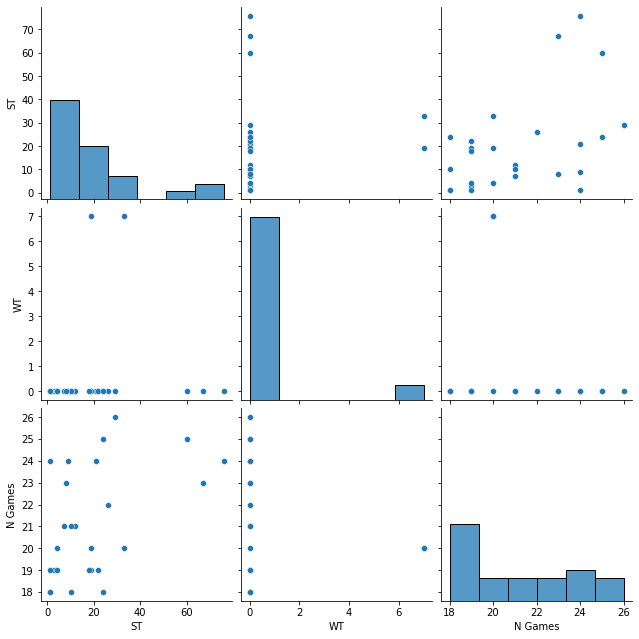

In [ ]:
#Grupo 5
print("GRUPO 5:")
is_G=final.loc[:, 'cluster']==5
C3_G=final[is_G]
print(C3_G.head())
print(C3_G.shape)

sb.pairplot(C3_G,
            height=3, 
            vars=['ST', 'WT', "N Games"],
            kind='scatter')
plt.show()

Apoyándonos con el pairplot y el gráfico 3D se evidencia que es un grupo el cual ya presenta una buena cantidad de participaciones
en los juegos olímpicos(todos sobrepasan los 15 juegos) pero todos estos países presentan menos de 80 medallas en los juegos de verano
y si nos vamos a los juegos de invierno no hay uno que supere las 10 medallas.

In [ ]:
resumen.iloc[5].unstack()

mean   min   max  count
ST       19.576923   1.0  76.0   26.0
WT        0.538462   0.0   7.0   26.0
N Games  21.115385  18.0  26.0   26.0

En la tabla se pudo evidenciar un total de 26 países los cuales en promedio presentan 21 participaciones en los juegos olímpicos (tanto de verano e invierno)
, con un máximo de 26 y mínimo de 18 participaciones. En cuanto a medallería en juegos de verano evidenciamos un promedio de 19 medallas con un pico máximo de 76 medallas
y un mínimo de 1 medalla. Si detallamos la medallería en los juegos de invierno se detalla en promedio 0.5 medallas con un máximo de 7 medallas y un mínimo de 0 medallas.

##Tendencias



1.   Al aumentar el número de clústers se seguirá viendo un grupo cuyos integrantes presentan mayor cantidad de participaciones o grupos con gran número de medallas en los juegos de verano, invierno o ambos, esto se puede notar en el silhouette score.
2.   Al analizar los clústeres formados luego del debido proceso de los datos, es notable la formación de clústeres cuyos datos tienen características similares, por ejemplo los grupos 0 y 5 son de los países con menos participaciones en juegos, mientras que el 1 y 4 son los que más tienen.
3.   Nos podemos percatar que en todos los clústeres en promedio  el medallero de los juegos de verano va a ser mayor que el de invierno, además es el clúster 2 el único donde el máximo de medallas de invierno es mayor al máximo de medallas de verano.
4.   Existe fuerte evidencia tanto en los gráficos como en las tablas que demuestran que los países integrantes de los grupos 1 y 4 son los de mayor tendencia tanto a participar como a ganar medallas en los juegos olímpicos de verano e invierno.
5.   Los clústeres de países que suelen ganar más medallas suelen estar más dispersos en gráficas de pares que aquellos que no.





###Análisis de colombia###

A continuación se presenta el sample del país Colombia:

In [ ]:
final[final.Paises.str.contains('Col', regex= True, na=False)]

Paises  N Summer  SG  SS  SB  ST  N Winter  WG  WS  WB  WT  \
101  Colombia (COL)        18   2   6  11  19         1   0   0   0   0   

     N Games  GG  GS  GB  Combined total      Z_CT  cluster  
101       19   2   6  11              19  0.348483        5

Se puede notar que Colombia hace parte del cluster 5 por lo que concluimos que tiene un número cercano al promedio de juegos pero poca tendencia a ganar medallas.

##Conclusiones generales##

Al analizar el conjunto de datos y sus correlaciones, se evidencia que las variables que pueden ser expresadas como un total (cómo SG, SS y SB que pueden ser resumidas en ST) no deben tenerse en cuenta ya que así se reduce la cantidad de información presente en el dataframe y se dejan las más significativas de acuerdo al objetivo. Estas variables de totales, son las que mejor resumen los datos ya que además de ser una suma de las otras variables, son las menos correlacionadas entre sí. 

El dendrograma como técnica puede ayudar a ver qué tan dispersos están los grupos, además de ayudar a esclarecer la cantidad de clústeres, para este caso, por ejemplo, se vio como la densidad de algunos grupos era mayor que la de otros ayudando así a establecer de manera más fácil los clústeres de acuerdo a esto.

Tanto K Means como Agglomerative clustering arrojaron resultados similares, pero por la forma en cómo se pueden visualizar los grupos se prefirió el último. Esta técnica fue útil debido a que permitió agrupar países con características similares y una varianza mínima entre ellos.